In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Preparing the Data

The ANN needs a little bit more tweaking before training. For this purpose I created a new pipeline. 

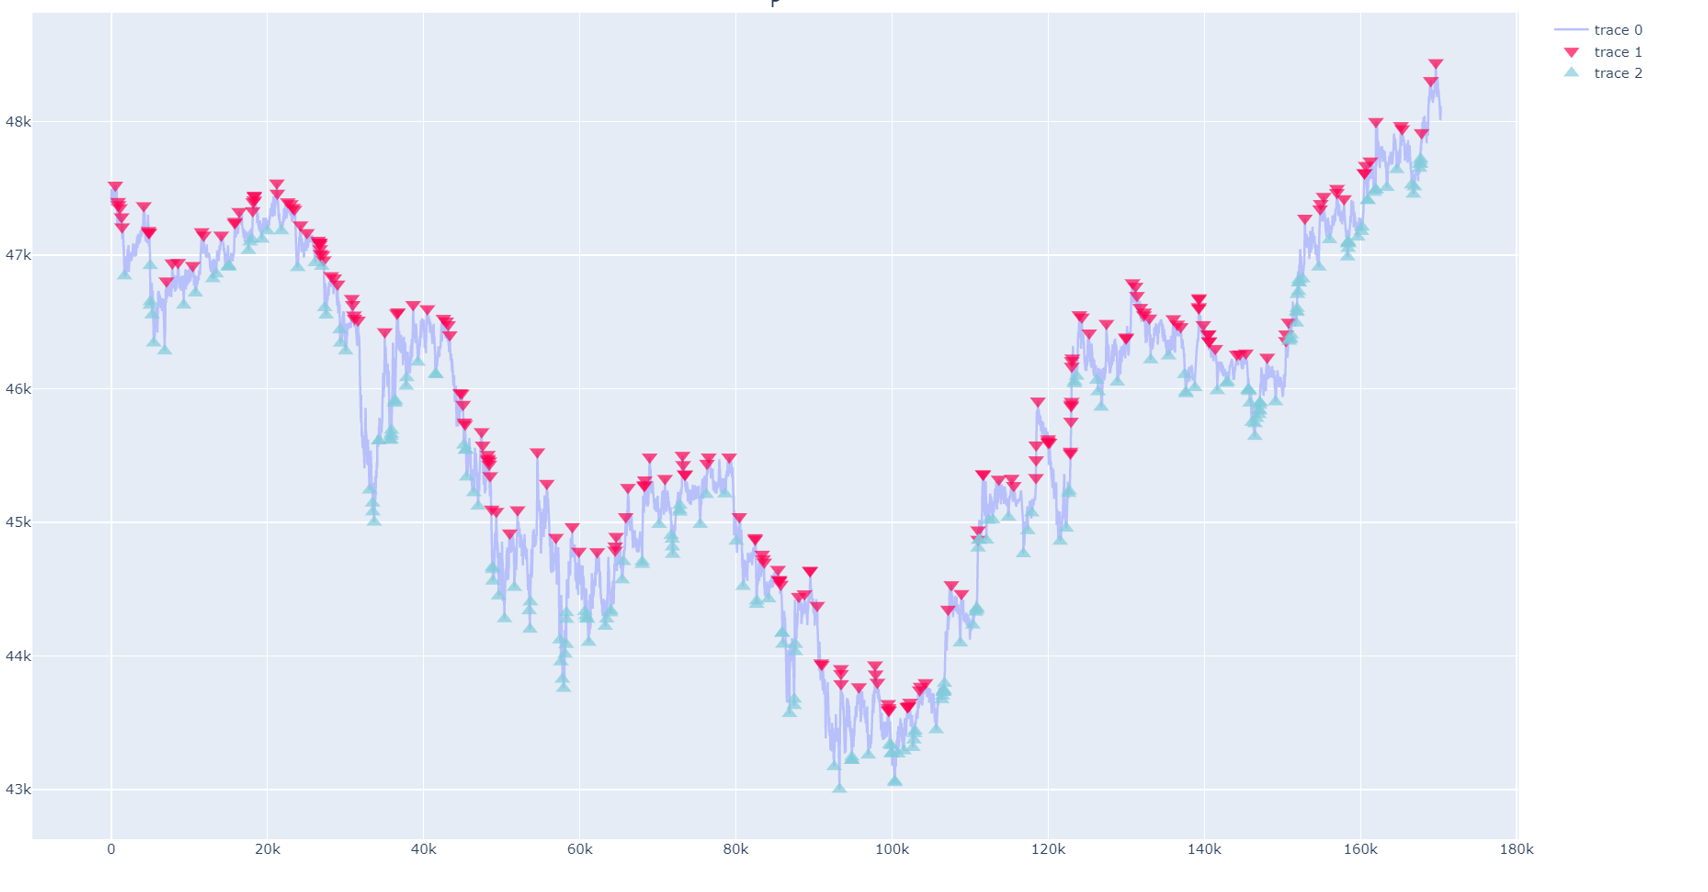

In [8]:
data = pd.read_csv('data/labeled.csv')

In [9]:
buy_signals = data.drop(data[data.position < 0].index)
sell_signals = data.drop(data[data.position > 0].index)

In [10]:
X = buy_signals.drop(['position', 'date', 'timestamp', 'days', 'midch', 'askvolch', 'bidvolch', 'change', 'midch', 'ask', 'bid'], axis=1).dropna().reset_index().drop('index', axis=1)
y = buy_signals.drop(['date', 'timestamp', 'days'], axis=1).dropna().reset_index()['position']

# Goal Structure

**X:** samples of multiple previous instances.  
>`ask levels`  
`bid levels`   
`price`   
`total volume`  
`trendline`  
`cross signal`  

Organized into a `10 x (size of X) - 10` matrix, normalized by the first value of each column.
 
**y:** binary label of entry or exit signals. 
 
model: two separate models for entry and exit signals for anomaly detection. Optimization with hyperopt.

In [11]:
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
169984    0.0
169985    0.0
169986    0.0
169987    0.0
169988    0.0
Name: position, Length: 169989, dtype: float64

In [12]:
X.head()

,askvol,bidvol,ask10,ask20,ask30,ask40,ask50,ask60,ask70,ask80,...,bid150,bid160,bid170,bid180,bid190,bid200,mid,trendline,cross_bidvol,cross_askvol
0,252.541256,415.246658,0.972579,0.000000,2.324742,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,47438.375,47435.910208,False,False
1,3.296665,42.048326,0.511630,0.557705,0.928427,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,47438.015,47436.226917,True,False
2,4.381000,4.861449,0.789145,2.859879,0.189658,0.070000,0.000000,0.07089,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,47435.595,47436.481083,False,False
3,123.175592,13.444089,1.233048,0.601328,2.037656,0.310918,0.077720,0.00000,0.01265,0.315596,...,0.0,0.0,0.0,0.0,0.0,0.0,47431.115,47436.741042,False,True
4,3.329348,7.852581,1.695791,0.181499,0.000000,0.105338,0.098619,1.00000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,47431.445,47437.003042,False,False


100%|██████████| 100/100 [00:00<00:00, 3605.34it/s]


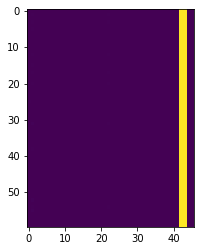

In [17]:
window_size = 60
X_new = np.zeros((len(X)-window_size, window_size, 46))
y_new = np.zeros((len(X)-window_size, 1))
sc = StandardScaler()

for i in tqdm(range(window_size, len(X))[:100]):
    window = X[i-window_size:i]
    #window = window.div(window.iloc[0])
    #window = sc.fit_transform(window)
    X_new[i-window_size] = window
    y_new[i-window_size] = y[i]

plt.imshow(X_new[9])

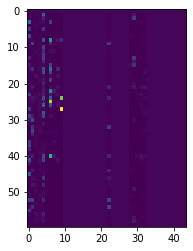

In [19]:
i = 91
w = X.drop(['cross_bidvol', 'cross_askvol'], axis=1)[i-window_size:i]
w = (w.div(w.iloc[0]) - 1).fillna(0).replace(np.inf, 0)
plt.imshow(w)

In [127]:
window_size = 20
X_new = np.zeros((len(X)-window_size, window_size, 44))
y_new = np.zeros((len(X)-window_size, 1))
sc = StandardScaler()

for i in tqdm(range(window_size, len(X))):
    window = X.drop(['cross_bidvol', 'cross_askvol'], axis=1)[i-window_size:i]
    window = (window.div(w.iloc[0]) - 1).fillna(0).replace(np.inf, 0)
    #window = sc.fit_transform(window)
    X_new[i-window_size] = np.nan_to_num(window, nan=0)
    y_new[i-window_size] = y[i]

In [128]:
np.save('data/X_normalized.npy', X_new, allow_pickle=True)
np.save('data/y_normalized.npy', y_new, allow_pickle=True)

100%|██████████| 100/100 [00:01<00:00, 80.82it/s]


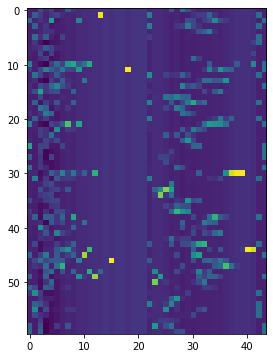

In [10]:
window_size = 60
X_new = np.zeros((len(X)-window_size, window_size, 44))
#y_new = np.zeros(len(X_buy)-window_size)
sc = StandardScaler()

for i in tqdm(range(window_size, len(X))[:100]):
    window = X.drop(['trendline', 'mid'], axis=1)[i-window_size:i]
    #window = window.div(window.iloc[0])
    window = sc.fit_transform(window)
    X_new[i-window_size] = window

y_new = np.array(y[window_size:])

plt.figure(figsize=(6, 6))
plt.imshow(X_new[9])

In [11]:
window_size = 60
X_new = np.zeros((len(X)-window_size, window_size, 44))
sc = StandardScaler()

for i in tqdm(range(window_size, len(X))):
    window = X.drop(['trendline', 'mid'], axis=1)[i-window_size:i]
    #window = window.div(window.iloc[0])
    window = sc.fit_transform(window)
    X_new[i-window_size] = window

y_new = np.array(y[window_size:])

100%|██████████| 169929/169929 [34:32<00:00, 81.99it/s]


In [12]:
np.save('data/X.npy', X_new, allow_pickle=True)
np.save('data/y.npy', y_new, allow_pickle=True)

In [24]:
X_new = np.asarray(X_new).astype(np.float32)
y_new = np.asarray(y_new).astype(np.float32)

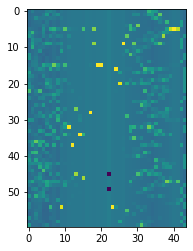

In [26]:
plt.imshow(X_test[11151])

In [27]:
y_train.shape

(135943,)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [5]:
X.shape

(169929, 60, 44)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
X_train = X_train.reshape(-1, 60, 44, 1)
X_test = X_test.reshape(-1, 60, 44, 1)
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [7]:
X_train.shape, y_train.shape

((118950, 60, 44, 1), (118950, 1))

# Model Design

In [8]:
if False:
    from keras.datasets import mnist
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    sample_shape = train_X[0].shape
    img_width, img_height = sample_shape[0], sample_shape[1]
    input_shape = (img_width, img_height, 1)
    train_X.shape, input_shape, train_y.shape

In [9]:
sample_shape = X_train[0].shape
img_width, img_height = sample_shape[0], sample_shape[1]
input_shape = (img_width, img_height, 1)

In [10]:
input_shape

(60, 44, 1)

In [11]:
KERNEL_SIZE = (5, 5)
POOL_SIZE = (2, 2)

In [12]:
# test-only, not to be used in practice
model = Sequential()

model.add(Conv2D(64, KERNEL_SIZE, input_shape=input_shape,
                 activation='relu', use_bias=False, strides=1, padding='same'))

model.add(Conv2D(64, KERNEL_SIZE, activation='relu',
                 strides=1, use_bias=False, padding='same'))

model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))

model.add(Conv2D(128, KERNEL_SIZE, activation='relu',
                 strides=1, use_bias=False, padding='same'))

model.add(Conv2D(128, KERNEL_SIZE, activation='relu',
                 strides=1, use_bias=False, padding='same'))

model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [13]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

In [14]:
model.fit(X_train, y_train, epochs=10, batch_size=512, verbose=1, validation_split=0.1)

Train on 107055 samples, validate on 11895 samples
Epoch 1/10
 11264/107055 [==>...........................] - ETA: 1:33 - loss: 0.2559 - auc: 0.3419 - binary_accuracy: 0.8728

KeyboardInterrupt: 

In [19]:
model.evaluate(X_test, y_test, batch_size=512)

50979/50979 [==============================] - 7s 138us/step


[0.014783640792602115, 0.6169777512550354, 0.998345136642456]

In [20]:
y_pred = model.predict(X_test)

In [21]:
sum(y_pred > 0.1)

array([8])

In [25]:
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

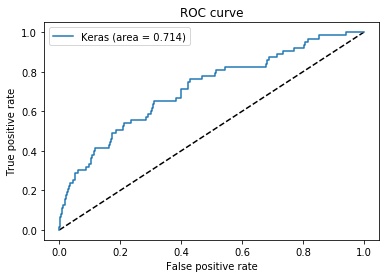

In [26]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred.sum()